#  Metrics errors (Klein et al. 2013)

This script computes the four Scalar Measures of the Fidelity of Model
Cloud Simulations described in Section 4 of Klein et al. (2013) for an example CMIP5 model

Returns: <br />
E_TCA:    total cloud amount error <br />
E_CP:     Cloud properties error <br />
E_LWCP:   LW-relevant Cloud properties error <br />
E_SWCP:   SW-relevant Cloud properties error <br />

Reference: Klein, S.A., Y. Zhang, M.D. Zelinka, R.N. Pincus, J.Boyle, and P.J. Gleckler, 2013: 
Are climate model simulations of clouds improving? An evaluation using the ISCCP simulator.  
J. Geophys. Res. 118, 1329-1342. doi: 10.1002/jgrd.50141

# Importe modules

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
# Klein modules
#import numpy.ma as ma
#from numpy.ma import rank
import cdms2 as cdms
#from cdms2 import MV2 as MV
import cdutil
import MV2 as MV
import numpy as np
import pylab as pl

# Functions definition

In [3]:
# Mes fonctions 
import sys
sys.path.append('/data/home/globc/peatier/CNRMppe')
import Fonctions
from Fonctions import get_wavg_budget_df
from Fonctions import wavg 
from Fonctions import plotlines_Xdf
from Fonctions import plotlines_1df
from Fonctions import Deltas_Lambda
from Fonctions import get_3D_xarr
from Fonctions import get_3D_budget_xarr
from Fonctions import get_3D_SW_xarr
from Fonctions import get_3D_LW_xarr

In [4]:
# Klein's functions

def add_cyclic(data):
    # Add Cyclic point around 360 degrees longitude:

    # This function assumes that your longitudes range from 0 to 360, not -180 to 180
    lons=data.getLongitude()[:]
    dx=np.gradient(lons)[-1]
    data2 = data(longitude=(0, dx+np.max(lons)), squeeze=True)
    return data2

###########################################################################
def reshape_generic(orig_data,data_to_match):

    # this function resizes and tiles orig_data the same shape as data_to_match
    # orig_data must have fewer dimensions than data_to_match

    A=orig_data.shape
    B=data_to_match.shape
    ndim_new = data_to_match.ndim

    # find index where B disagrees with A
    #disagree=np.setdiff1d(B,A)
    agree=np.in1d(B,A)
    j=[]
    for i in range(len(B)):
        ndim_orig = orig_data.ndim
        if agree[i]==False:
            j=np.append(j,i)
            new = np.expand_dims(orig_data,axis=ndim_orig)
            NEW = np.tile(new,[B[i]])
            try:
                new_mask = np.expand_dims(orig_data.mask,axis=ndim_orig)
                MASK = np.tile(new_mask,[B[i]])
                orig_data = np.ma.array(NEW,mask=MASK)
            except:
                orig_data = np.ma.array(NEW)

    # need to move axes around
    C=orig_data.shape
    i=-1
    while B!=C:
        i+=1
        if i==len(B):
            i=0
        C=orig_data.shape
        #print C
        if C[i]!=B[i]:
            orig_data = np.moveaxis(orig_data, i, B.index(C[i])) # (a, source, destination)

    return orig_data

###########################################################################
def nanarray(vector):

    # this generates a masked array with the size given by vector
    # example: vector = (90,144,28)

    # similar to this=NaN*ones(x,y,z) in matlab

    this=MV.zeros(vector)
    this=MV.masked_where(this==0,this)

    return this

###########################################################################
def map_SWkern_to_lon(Ksw,albcsmap):

    from scipy.interpolate import interp1d
    ## Map each location's clear-sky surface albedo to the correct albedo bin
    # Ksw is size 12,7,7,lats,3
    # albcsmap is size A,lats,lons
    albcs=np.arange(0.0,1.5,0.5)
    A=albcsmap.shape[0]
    TT=Ksw.shape[1]
    PP=Ksw.shape[2]
    lenlat=Ksw.shape[3]
    lenlon=albcsmap.shape[2]
    SWkernel_map=nanarray((A,TT,PP,lenlat,lenlon))
    for M in range(A):
        MM=M
        while MM>11:
            MM=MM-12
        for LA in range(lenlat):
            alon=albcsmap[M,LA,:]
            # interp1d can't handle mask but it can deal with NaN (?)
            try:
                alon2=MV.where(alon.mask,np.nan,alon)
            except:
                alon2=alon
            if np.ma.count(alon2)>1: # at least 1 unmasked value
                if len(pl.find(Ksw[MM,:,:,LA,:]>0))==0:
                    SWkernel_map[M,:,:,LA,:] = 0
                else:
                    f = interp1d(albcs,Ksw[MM,:,:,LA,:],axis=2)
                    ynew = f(alon2.data)
                    ynew=MV.masked_where(alon2.mask,ynew)
                    SWkernel_map[M,:,:,LA,:] = ynew
            else:
                continue

    return SWkernel_map


In [5]:
def mod_load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon', 'plev7', 'tau'])
    df1['month']=pd.DatetimeIndex(df1['time']).month # time in years
    df_mean=df1.groupby(['month', 'lat', 'lon', 'plev7', 'tau']).mean()
    
    return df_mean

# Load data

In [6]:
###########################################################################
# MAIN ROUTINE FOLLOWS
###########################################################################

datadir = '/data/home/globc/peatier/CNRMppe/klein2013-cloud-error-metrics/data/'

# Load in the Zelinka et al 2012 kernels:
f=cdms.open(datadir+'cloud_kernels2.nc')
LWkernel0=f('LWkernel')
SWkernel0=f('SWkernel')
f.close()

# Take only the portion of the kernel histogram where there are obs (ignore first tau bin)
SWkernel = SWkernel0[:,1:,:]
LWkernel = LWkernel0[:,1:,:]
del(LWkernel0,SWkernel0)

albcs=np.arange(0.0,1.5,0.5) # the clear-sky albedos over which the kernel is computed

######################################################
############# Load in ISCCP observations #############
######################################################
f=cdms.open(datadir+'AC_clisccp.nc','r')
obs_clisccp=f('avgclisccp',squeeze=1)
f.close()

grid = obs_clisccp.getGrid()

# Flip the CTP dimension to go SFC to TOA, set to units of %, and ignore the 1st TAU bin:
obs_clisccp_grd = 100*obs_clisccp[:,1:,-1::-1,:]

######################################################
############# Load in MODIS observations #############
######################################################
f=cdms.open(datadir+'AC_clmodis.nc')
obs_clmodis=f('avgclisccp',squeeze=1)  # not a typo
f.close()

# Flip the CTP dimension to go SFC to TOA, set to units of %, and ignore the 1st TAU bin:
obs_clmodis_grd = 100*obs_clmodis[:,1:,-1::-1,:]

agg_mod_clisccp_bias = nanarray((12,2,3,60,144)) # (month, tau_bins, CTP_bins, lat, lon)
agg_mod_SW_bias = nanarray((12,2,3,60,144)) # (month, tau_bins, CTP_bins, lat, lon)
agg_mod_LW_bias = nanarray((12,2,3,60,144)) # (month, tau_bins, CTP_bins, lat, lon)

agg_obs_clisccp_bias=nanarray((12,2,3,60,144))
agg_obs_SW_bias=nanarray((12,2,3,60,144))
agg_obs_LW_bias=nanarray((12,2,3,60,144))

In [7]:
######################################################
############# Load in CLISCCP from PPE #############
######################################################

# Load the AMIP simulation from the second PPE:

path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
variables = ['clisccp']

# The amip experiment : 

#p301',  'p302',  'p304',  'p308', 'p309', 
nb_p_list = ['p311', 'p312', 'p314', 'p316',
                    'p317', 'p319', 'p320', 'p321', 'p322', 'p324', 'p325', 'p326', 
                    'p329', 'p330', 'p331', 'p332', 'p335', 'p336', 'p337' ,'p338', 
                    'p340', 'p341', 'p343', 'p344', 'p346', 'p347', 'p348', 'p349', 
                    'p350', 'p353', 'p355', 'p357', 'p359', 'p360', 
                    'p361', 'p363', 'p365', 'p367', 'p368', 'p369', 
                    'p372', 'p373', 'p374', 'p375', 'p376', 'p378', 'p381', 'p382', 
                    'p384', 'p386', 'p388', 'p389', 'p391', 'p392', 'p393', 
                    'p394', 'p395', 'p396', 'p398', 'p399', 'p400', 'p404', 
                    'p406', 'p407', 'p409', 'p410', 'p411', 'p412']
N=len(nb_p_list)
PPE={}
i = 0
while i<N:
    nb_p = nb_p_list[i]
    print(nb_p)
    path = path_PPE+'CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    filename = 'clisccp_CFmon_CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2_gr_*.nc'
    
    # Load data and compute Annual Cycle :
    df = mod_load_monthly_clim(path, filename, variables)
    
    # Store result
    PPE[str(nb_p)] = df
    
    i=i+1


p311
p312
p314
p316
p317
p319
p320
p321
p322
p324
p325
p326
p329
p330
p331
p332
p335
p336
p337
p338
p340
p341
p343
p344
p346
p347
p348
p349
p350
p353
p355
p357
p359
p360
p361
p363
p365
p367
p368
p369
p372
p373
p374
p375
p376
p378
p381
p382
p384
p386
p388
p389
p391
p392
p393
p394
p395
p396
p398
p399
p400
p404
p406
p407
p409
p410
p411
p412


# Compute clear-sky surface albedo

In [8]:
######################################################
########## Compute clear-sky surface albedo ##########
######################################################
#f=cdms.open(datadir+'rsdscs_Amon_MPI-ESM-LR_amip_r1i1p1_197901-200812.nc','r')
#rsdscs0 = f('rsdscs',squeeze=1) # Clearsky downwelling solar flux at surface
#f=cdms.open(datadir+'rsuscs_Amon_MPI-ESM-LR_amip_r1i1p1_197901-200812.nc','r')
#rsuscs0 = f('rsuscs',squeeze=1) # Clearsky upwelling solar flux at surface
#f.close()

# Compute Climatological Annual Cycle:
#rsdscs = cdutil.ANNUALCYCLE.climatology(rsdscs0) #(12,...)
#rsuscs = cdutil.ANNUALCYCLE.climatology(rsuscs0) #(12,...)

#albcs = rsuscs/rsdscs
#albcs=MV.where(albcs>1.,1,albcs) # where(condition, x, y) is x where condition is true, y otherwise
#albcs=MV.where(albcs<0.,0,albcs)


# Regrid everything to the kernel grid:
#albcs = add_cyclic(albcs)
#albcs_grd = albcs.regrid(grid,regridTool="esmf",regridMethod = "linear")
#clisccp = add_cyclic(clisccp)
#clisccp_grd = clisccp.regrid(grid,regridTool="esmf",regridMethod = "linear")

# Compute Klein et al. (2013) metrics

## E_TCA (Total Cloud Amount Metric)

### Regrid

In [9]:
# On regrille les données du modèle sur la grille des observations, récupérer avec ncdump -v lat obs.nc

lat = arange(-89,90,2)
lon = arange(1.25,359,2.50)

for i in nb_p_list:
    print(i)
    df = PPE[str(i)].to_xarray()
    mod_interp=df['clisccp'].interp(lat=lat, lon=lon)
    PPE[str(i)] = mod_interp.to_dataframe()

p311
p312
p314
p316
p317
p319
p320
p321
p322
p324
p325
p326
p329
p330
p331
p332
p335
p336
p337
p338
p340
p341
p343
p344
p346
p347
p348
p349
p350
p353
p355
p357
p359
p360
p361
p363
p365
p367
p368
p369
p372
p373
p374
p375
p376
p378
p381
p382
p384
p386
p388
p389
p391
p392
p393
p394
p395
p396
p398
p399
p400
p404
p406
p407
p409
p410
p411
p412


### Observations

In [10]:
eq60 = cdutil.region.domain(latitude=(-60.,60.)) # equatorward of 60

# take only clouds with tau>1.3 between 60S-60N
obs_clisccp_eq60 = eq60.select(obs_clisccp_grd[:,1:,:])
obs_clmodis_eq60 = eq60.select(obs_clmodis_grd[:,1:,:])
# sum over CTP and TAU:
#obs_cltisccp_eq60 = MV.sum(MV.sum(obs_clisccp_eq60,axis=1),axis=1) # (time, lat, lon)
obs_cltisccp_eq60 = MV.sum(MV.sum(obs_clisccp_eq60,axis=1),axis=1) # (time, lat, lon)
obs_cltmodis_eq60 = MV.sum(MV.sum(obs_clmodis_eq60,axis=1),axis=1) # (time, lat, lon)

### Models

In [11]:
# take only clouds with tau>1.3 between 60S-60N and sum over CTP and TAU : 
def filter_sum(df) :

    df1=df.reset_index(level=['month','lat','lon','plev7','tau'])
    df_filtered_tau = df1[df1['tau'] >1.3]
    df_filtered_latN = df_filtered_tau[df_filtered_tau['lat']<60.0]
    df_filtered = df_filtered_latN[df_filtered_latN['lat']>-60.0]

    df_sum=df_filtered.groupby(['month', 'lat', 'lon']).sum()
    df_final = df_sum.drop(labels=['plev7', 'tau'], axis=1)
    
    return df_final

In [12]:
## MODELS
PPE_sum = {}
for i in nb_p_list:
    print(i)
    df=PPE[str(i)]
    # take only clouds with tau>1.3 between 60S-60N and sum over CTP and TAU : 
    mod_clisccp_eq60 = filter_sum(df)

    # store result
    PPE_sum[str(i)] = mod_clisccp_eq60

p311
p312
p314
p316
p317
p319
p320
p321
p322
p324
p325
p326
p329
p330
p331
p332
p335
p336
p337
p338
p340
p341
p343
p344
p346
p347
p348
p349
p350
p353
p355
p357
p359
p360
p361
p363
p365
p367
p368
p369
p372
p373
p374
p375
p376
p378
p381
p382
p384
p386
p388
p389
p391
p392
p393
p394
p395
p396
p398
p399
p400
p404
p406
p407
p409
p410
p411
p412


### E_TCA : (Eq. 3 in Klein et al. (2013)) 

#### Denominator

In [13]:
# Create map of area weights
lat=grid.getLatitude()[:]
coslats=np.cos(lat*np.pi/180)
w_k0=coslats/np.sum(np.cos(lat*np.pi/180))
w_k = w_k0[15:-15] # equatorward of 60

# 1) Denominator (Eq. 3 in Klein et al. (2013))
avg = cdutil.averager(MV.average(obs_cltisccp_eq60,axis=0), axis='xy', weights='weighted') # (scalar)
#rep_avg = reshape_generic(avg,obs_cltisccp_eq60) # (time, lat, lon)
anom = obs_cltisccp_eq60 - avg # anomaly of obs from its spatio-temporal mean
area_wts2 = reshape_generic(w_k,anom) # (time, lat, lon)
E_TCA_denom = np.ma.sqrt(MV.sum(area_wts2*anom**2)) # (scalar)
#E_TCA_denom = np.ma.sqrt(cdutil.averager(MV.average(anom**2,axis=0), axis='xy', weights='weighted')) # (scalar)

#### Numerator and division

In [14]:
#...................................................................
# GLOBAL MEAN WEIGHTED WITH COS(LAT)

import xarray as xr
import numpy as np
import pandas as pd


def wavg(df, start_yr, variables):
    # First, we need to convert latitude to radians and the time into year
    df1=df.reset_index(level=['month', 'lat'])
    df1['latr'] = np.deg2rad(df1['lat']) # lat in radians 


    # Then, we find the zonal mean by averaging along the latitude circles
    df2=df1.groupby(['month', 'lat']).mean()

    # Finally, we use the cosine of the converted latitudes as weights for the average
    df2['weights'] = np.cos(df2['latr'])
    result=pd.DataFrame()
    df2_tmp=df2.groupby(['month']).mean()
    result[variables]=df2_tmp[variables]
    N=len(result)
    YR=start_yr
    i=0
    while i < N:
        yr=YR+i
        tmp=df2.loc[yr]
        n=len(variables)
        j=0
        while j < n:
            t = (tmp[variables[j]]*tmp['weights']).sum()/tmp['weights'].sum()
            result[variables[j]].iloc[i]=t
            j = j + 1
        i = i + 1

    r = result.mean()
    return r


In [15]:
# 2) Numerator
anom_dict={}
E_TCA={}
for i in nb_p_list:
    print(i)
    df = PPE_sum[str(i)]
    mod_cltisccp_eq60 = df.to_xarray()
    anom = mod_cltisccp_eq60 - obs_cltisccp_eq60  # (time, lat, lon)
    # Créer fonction de moyenne spatiale pondérée avec mise au carrée 
    df_anom = anom.to_dataframe()
    anom_dict[str(i)] = df_anom
    df_anom['clisccp'] = df_anom['clisccp']**2
    E_TCA_numer_tmp = wavg(df_anom,1,['clisccp'])
    E_TCA_numer = sqrt(E_TCA_numer_tmp)
    #E_TCA_numer = np.ma.sqrt(MV.sum(area_wts2*anom**2)) # (scalar)
    #E_TCA_numer = np.ma.sqrt(cdutil.averager(MV.average(anom**2,axis=0), axis='xy', weights='weighted')) # (scalar)
    
    
    E_TCA_mod = E_TCA_numer/E_TCA_denom
    E_TCA[str(i)] = E_TCA_mod

p311
p312
p314
p316
p317
p319
p320
p321
p322
p324
p325
p326
p329
p330
p331
p332
p335
p336
p337
p338
p340
p341
p343
p344
p346
p347
p348
p349
p350
p353
p355
p357
p359
p360
p361
p363
p365
p367
p368
p369
p372
p373
p374
p375
p376
p378
p381
p382
p384
p386
p388
p389
p391
p392
p393
p394
p395
p396
p398
p399
p400
p404
p406
p407
p409
p410
p411
p412


### Create plots

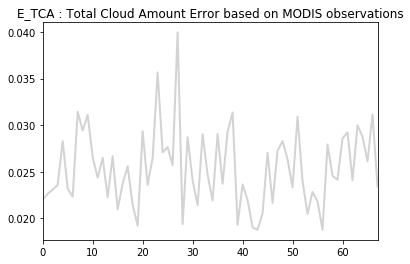

In [16]:
n = len(E_TCA)
E_TCA_list = [None]*n
E_TCA_list[:] = [E_TCA[str(i)] for i in nb_p_list]
E_TCA_df = pd.DataFrame(E_TCA_list)

# Plotting settings
title = 'E_TCA : Total Cloud Amount Error based on MODIS observations'

E_TCA_df['clisccp'].plot(kind='line',title=title,legend=False, 
                         color='lightgrey',linewidth=2.0)
plt.show()

In [18]:
# Plot error VS Feedbacks
Feedbacks = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/files/npy/Net_feedbacks.npy")
E_TCA_df['N'] = Feedbacks
E_TCA_df

,clisccp,N
0,0.022015,-0.789073
1,0.022633,-1.666454
2,0.023066,-1.214114
3,0.023569,-1.292415
4,0.028284,-0.756525
...,...,...
63,0.029977,-1.321747
64,0.028763,-1.604550
65,0.026109,-1.118935
66,0.031134,-1.279246


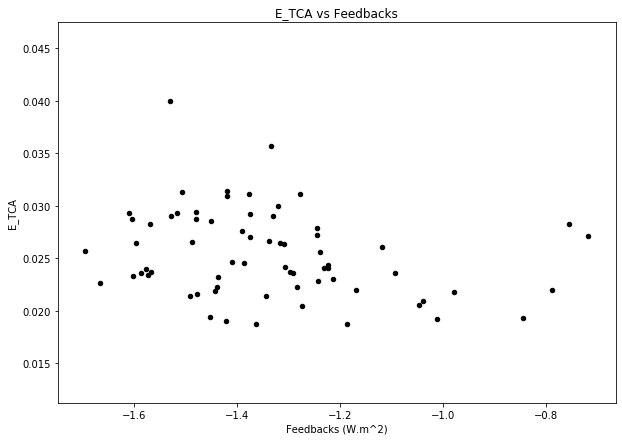

In [19]:
ax = plt.gca()
title = 'E_TCA vs Feedbacks'
E_TCA_df.plot(kind='scatter', x='N', y='clisccp', color='black', figsize=(10, 7), 
                     style='.', ax = ax)
#plt.plot(X_test, y_pred, color='blue', linewidth=1.0)

plt.xlabel('Feedbacks (W.m^2)')
plt.ylabel('E_TCA')
plt.title(title)
plt.show()

### E_ctp-tau : 

In [124]:
anom_dict

{'p311':                       clisccp
 lat lon    month             
 -59 1.25   1         0.285312
            2         6.399833
            3        18.698313
            4         7.870592
            5        10.845764
 ...                       ...
  59 358.75 8      4988.881558
            9      4701.529411
            10     4723.951573
            11     4700.832158
            12             NaN
 
 [103680 rows x 1 columns], 'p312':                       clisccp
 lat lon    month             
 -59 1.25   1       146.947189
            2       144.134384
            3       114.141331
            4       139.376775
            5        91.867844
 ...                       ...
  59 358.75 8      4988.881558
            9      4701.529411
            10     4723.951573
            11     4700.832158
            12             NaN
 
 [103680 rows x 1 columns], 'p314':                       clisccp
 lat lon    month             
 -59 1.25   1       245.531795
            2      

In [118]:
# take only clouds with tau>1.3 between 60S-60N and sum over CTP and TAU : 
def filter_36tau(df) :

    df1=df.reset_index(level=['month','lat','lon','plev7','tau'])
    df_filtered_tau = df1[df1['tau'] >3.6]
    df_filtered_latN = df_filtered_tau[df_filtered_tau['lat']<60.0]
    df_filtered = df_filtered_latN[df_filtered_latN['lat']>-60.0]

    #df_sum=df_filtered.groupby(['month', 'lat', 'lon']).sum()
    #df_final = df_sum.drop(labels=['plev7', 'tau'], axis=1)
    
    return df_filtered

In [ ]:
## Compute Cloud Fraction Histogram Anomalies w.r.t. observations
clisccp_bias = clisccp_grd - obs_clisccp_grd

In [119]:
########################################################
# CLOUD PROPERTY METRICS
########################################################
# take only clouds with tau>3.6 between 60S-60N observations :
obs_clisccp_eq60 = eq60.select(obs_clisccp_grd[:,2:,:])

# Model :
clisccp_bias_eq60 = eq60.select(clisccp_bias[:,2:,:])

for i in nb_p_list:
    df = anom_dict[str(i)]
    mod_clisccp_eq60 = filter_36tau(df)
#LWkernel_eq60 = eq60.select(LWkernel_map[:,2:,:])
#SWkernel_eq60 = eq60.select(SWkernel_map[:,2:,:])



NameError: name 'clisccp_bias' is not defined

In [ ]:
# Compute anomaly of obs histogram from its spatio-temporal mean
avg_obs_clisccp_eq60 = cdutil.averager(MV.average(obs_clisccp_eq60,0), axis='xy', weights='weighted') # (TAU,CTP)
rep_avg_obs_clisccp_eq60 = reshape_generic(avg_obs_clisccp_eq60,obs_clisccp_eq60) # (time, TAU, CTP, lat, lon)
anom_obs_clisccp_eq60 = obs_clisccp_eq60 - rep_avg_obs_clisccp_eq60 # anomaly of obs from its spatio-temporal mean

## Compute radiative impacts of cloud fraction anomalies
#mod_SW_bias = eq60.select(SW[:,2:,:])
#obs_SW_bias = anom_obs_clisccp_eq60*SWkernel_eq60
#mod_LW_bias = eq60.select(LW[:,2:,:])
#obs_LW_bias = anom_obs_clisccp_eq60*LWkernel_eq60

## Aggregate high, mid, and low clouds over medium and thick ISCCP ranges
Psec_name = ['LO','MID','HI']
Psections=[slice(0,2),slice(2,4),slice(4,7)]
Psec_dic=dict(zip(Psec_name,Psections))
Tsec_name = ['MED','THICK']
Tsections=[slice(0,2),slice(2,4)]
Tsec_dic=dict(zip(Tsec_name,Tsections))

tt=-1
for Tsec in Tsec_name:
    tt+=1
    TT=Tsec_dic[Tsec]
    pp=-1
    for Psec in Psec_name:
        pp+=1
        PP=Psec_dic[Psec]
        #agg_obs_SW_bias[:,tt,pp,:] = MV.sum(MV.sum(obs_SW_bias[:,TT,PP,:],axis=1),axis=1)
        #agg_mod_SW_bias[:,tt,pp,:] = MV.sum(MV.sum(mod_SW_bias[:,TT,PP,:],axis=1),axis=1)
        #agg_obs_LW_bias[:,tt,pp,:] = MV.sum(MV.sum(obs_LW_bias[:,TT,PP,:],axis=1),axis=1)
        #agg_mod_LW_bias[:,tt,pp,:] = MV.sum(MV.sum(mod_LW_bias[:,TT,PP,:],axis=1),axis=1)
        agg_obs_clisccp_bias[:,tt,pp,:] = MV.sum(MV.sum(anom_obs_clisccp_eq60[:,TT,PP,:],axis=1),axis=1)
        agg_mod_clisccp_bias[:,tt,pp,:] = MV.sum(MV.sum(clisccp_bias_eq60[:,TT,PP,:],axis=1),axis=1)

## Compute E_ctp-tau -- Cloud properties error 
ctot = MV.sum(MV.sum(agg_mod_clisccp_bias**2,axis=1),axis=1)/6;
ctot.setAxisList(clisccp_bias_eq60[:,0,0,:].getAxisList())
E_ctpt_numer = np.ma.sqrt(MV.sum(area_wts2*ctot)) # (scalar)
#E_ctpt_numer = np.ma.sqrt(cdutil.averager(ctot, axis='xy', weights='weighted')) # (time)

ctot = MV.sum(MV.sum(agg_obs_clisccp_bias**2,axis=1),axis=1)/6;
ctot.setAxisList(clisccp_bias_eq60[:,0,0,:].getAxisList())
E_ctpt_denom = np.ma.sqrt(MV.sum(area_wts2*ctot)) # (scalar)
#E_ctpt_denom = np.ma.sqrt(cdutil.averager(ctot, axis='xy', weights='weighted')) # (time)

E_ctpt_mod = E_ctpt_numer/E_ctpt_denom